In [1]:
import pandas as pd

C:\Users\afafc\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Step 1: Explore the dataset
First, let’s look at the schema, check for missing values, and preview a few rows of the dataset.  
This helps us understand what cleaning will be needed later.

In [2]:
#Load the raw data UCI Online Retail dataset
df = pd.read_excel("D:\DataScienceProjects\DataSets\online_retail_dataset\Online_Retail.xlsx")

In [3]:
## Check column data types, non-null counts, and overall schema
df.info()

# Count missing values in each column to decide cleaning steps
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Preview the first few rows to understand structure and spot obvious issues
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [5]:
# Clean up column names. Some columns in the raw dataset (like 'InvoiceNo ', 'CustomerID ') 
# have trailing spaces. renaming with str.strip removes whitespace from all column names 
# so we don’t run into key errors later (e.g., 'InvoiceNo' vs 'InvoiceNo ').
#df = df.rename(columns=str.strip)

## Step 2: Clean the dataset
Goals:
1) Standardise column names and types (IDs as strings, dates as datetime)
2) Keep only rows we can tie to a customer (drop missing CustomerID) 
3) Remove returns/cancellations from the sales table (Quantity > 0, UnitPrice > 0)
4) Create a Revenue column for downstream metrics

We’ll also log how many rows we removed at each step for transparency.


In [6]:
# Track starting shape for transparency
start_rows = len(df)   
start_revenue = (df["Quantity"] * df["UnitPrice"]).sum()

# 1) Standardise headers: strip leading/trailing spaces
df = df.rename(columns=str.strip)

# 2) Drop rows without CustomerID (cannot do lifecycle/CLV without an ID)
missing_id = df["CustomerID"].isna().sum()
df = df.dropna(subset = ["CustomerID"]).copy()

# 3) Cast identifiers and dates

# Convert CustomerID from float → int → string.
# Step 1 (int): removes the ".0" caused by storing IDs as float when NaN was present.
# Step 2 (str): ensures IDs are treated as labels, not numbers.
df["CustomerID"] = df["CustomerID"].astype(int).astype(str)

# InvoiceNo is an identifier; treat as string
df["InvoiceNo"] = df["InvoiceNo"].astype(str).str.strip()


# InvoiceDate was already parsed as datetime on load (see df.info()).
# Reapplying pd.to_datetime as a safeguard ensures it's datetime in case the source changes
# (e.g., if loaded from CSV or a different source like database or API) and coerces any invalid values to NaT.
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")


# 4) Keep only valid sales (exclude returns/cancellations and zero-priced lines)
before_valid = len(df)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()
removed_invalid = before_valid - len(df)

# 5) Create Revenue once and reuse everywhere
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Log the impact of cleaning
print(f"Start rows: {start_rows:,}")
print(f"Rows with missing CustomerID dropped: {missing_id:,}")
print(f"Rows removed due to non-positive quantity/price: {removed_invalid:,}")
print(f"Final rows: {len(df):,}")


Start rows: 541,909
Rows with missing CustomerID dropped: 135,080
Rows removed due to non-positive quantity/price: 8,945
Final rows: 397,884


## Step 3: Post-clean sanity checks
Quick checks to confirm the dataset is ready for lifecycle analysis.

In [7]:
# Unique customers, date range, and remaining nulls
n_customers = df["CustomerID"].nunique()
date_min, date_max = df["InvoiceDate"].min(), df["InvoiceDate"].max()

print(f"Unique Customers: {n_customers:,}")
print(f"Date range: {date_min.date()} → {date_max.date()}")
print("\nNulls after cleaning:")
print(df.isnull().sum())

 
#top products by revenue (quick sniff test)
top_products = (
    df.groupby("StockCode", as_index=False)
      .agg(Revenue=("Revenue","sum"), Description = ("Description", "first"))
      .sort_values("Revenue", ascending=False)
      .reset_index(drop = True)
      .head(5)
)
top_products

Unique Customers: 4,338
Date range: 2010-12-01 → 2011-12-09

Nulls after cleaning:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Revenue        0
dtype: int64


,StockCode,Revenue,Description
0,23843,168469.60,"PAPER CRAFT , LITTLE BIRDIE"
1,22423,142592.95,REGENCY CAKESTAND 3 TIER
2,85123A,100603.50,WHITE HANGING HEART T-LIGHT HOLDER
3,85099B,85220.78,JUMBO BAG RED RETROSPOT
4,23166,81416.73,MEDIUM CERAMIC TOP STORAGE JAR


## Step 4: Build an Orders table


The raw dataset is at the **line-item level** — each row represents a single product in an invoice.  
For example, if a customer bought 3 different items in one purchase, that invoice will appear as 3 rows.

**Why this is a problem:**  
Customer lifecycle analysis (new vs repeat, retention, CLV) happens at the **order level** —  
we care about *when* customers placed orders and *how much* they spent in total, not the individual items inside each basket.

**Solution:**  
Aggregate all line items that belong to the same invoice into a single row.  
This gives us an **Orders Table** where each row = one order per customer, with:
- `OrderDate` → when the order was placed (minimum InvoiceDate - In this dataset, min, max, or first would give the same result, but min is chosen as a clear and robust way to define the start of an order.  )  
- `Revenue` → total revenue for that order (sum of line items)  
- `CustomerID` → who placed the order  

**Example**

Raw data (line items for one invoice):
| InvoiceNo | CustomerID | StockCode | Description                       | Quantity | Revenue |
|-----------|------------|-----------|-----------------------------------|----------|---------|
| 536365    | 17850      | 85123A    | White Hanging Heart T-Light Holder | 6        | 15.30   |
| 536365    | 17850      | 71053     | White Metal Lantern               | 6        | 9.00    |
| 536365    | 17850      | 84406B    | Cream Cupid Hearts Coat Hanger    | 8        | 20.40   |

Aggregated Orders Table:
| InvoiceNo | CustomerID | OrderDate   | Revenue |
|-----------|------------|-------------|---------|
| 536365    | 17850      | 2010-12-01  | 44.70   |

Now, each row represents a full purchase event, making it easier to track new vs repeat orders, build retention cohorts, and calculate CLV.


In [8]:
# Aggregate to order level
orders = (
    df.groupby(["InvoiceNo", "CustomerID"], as_index=False)
      .agg(
          OrderDate=("InvoiceDate", "min"),
          Revenue=("Revenue", "sum")
      )
)

# Month bucket for time-based analysis
orders["OrderMonth"] = orders["OrderDate"].values.astype("datetime64[M]")

# First purchase per customer (enables new vs repeat flags later)
first_purchase = (
    orders.groupby("CustomerID", as_index=False)
          .agg(FirstOrder=("OrderDate","min"))
)
orders = orders.merge(first_purchase, on="CustomerID", how="left")
#orders["IsNew"] = orders["OrderDate"] == orders["FirstOrder"]
# flag only the very first order per customer as new
orders["IsNew"] = orders.groupby("CustomerID").cumcount() == 0

print(f"Orders table: {len(orders):,} rows, {orders['CustomerID'].nunique():,} customers")
orders.head()



Orders table: 18,532 rows, 4,338 customers


,InvoiceNo,CustomerID,OrderDate,Revenue,OrderMonth,FirstOrder,IsNew
0,536365,17850,2010-12-01 08:26:00,139.12,2010-12-01,2010-12-01 08:26:00,True
1,536366,17850,2010-12-01 08:28:00,22.20,2010-12-01,2010-12-01 08:26:00,False
2,536367,13047,2010-12-01 08:34:00,278.73,2010-12-01,2010-12-01 08:34:00,True
3,536368,13047,2010-12-01 08:34:00,70.05,2010-12-01,2010-12-01 08:34:00,False
4,536369,13047,2010-12-01 08:35:00,17.85,2010-12-01,2010-12-01 08:34:00,False


## Step 5: Save clean artifacts
Store clean sales and orders for reuse (e.g., Power BI, later notebooks).

In [9]:
# Save as Parquet (compact and fast). Use CSV if you prefer.
df.to_csv("D:\DataScienceProjects\DataSets\online_retail_dataset\sales.csv", index=False)
orders.to_csv("D:\DataScienceProjects\DataSets\online_retail_dataset\orders.csv", index=False)

print("Saved")

Saved


## Customer Lifecycle Metrics (monthly KPIs)

Now that we have the **Orders Table**, we can track how the business evolves month by month.  
The goal is to understand both acquisition (new customers) and retention (repeat customers).

**Approach:**
1. Create an `OrderMonth` column by bucketing order dates into Year-Month.
2. Identify each customer's **first-ever order**.  
   - We use `groupby("CustomerID").cumcount()==0` to ensure each customer is only flagged once as "new".
   - This avoids overcounting cases where multiple invoices share the same first timestamp.
3. Aggregate by month to calculate:
   - **Orders** → number of unique invoices
   - **Revenue** → total sales value
   - **Customers** → distinct customers active that month
   - **NewCustomers** → customers making their first-ever order that month
   - **RepeatCustomers** → Customers − NewCustomers
   - **AOV (Average Order Value)** → Revenue ÷ Orders

**Why this matters:**
- Shows whether growth is being driven by **new acquisition** or **retention of existing customers**.
- Highlights seasonal spikes (e.g., holiday months).
- Average Order Value (AOV) helps explain revenue changes: are customers buying more, or are there simply more customers?



In [10]:
# Aggregate monthly KPIs

monthly_metrics = (
    orders.groupby("OrderMonth")
          .agg(
              Orders=("InvoiceNo", "nunique"),       # number of unique orders
              Revenue=("Revenue", "sum"),            # total revenue
              Customers=("CustomerID", "nunique"),   # active customers
              NewCustomers=("IsNew", "sum")          # new customers count
          )
          .reset_index()
)

# Derive repeat customers = active - new
monthly_metrics["RepeatCustomers"] = monthly_metrics["Customers"] - monthly_metrics["NewCustomers"]

# Average order value (AOV) = Revenue / Orders
monthly_metrics["AOV"] = monthly_metrics["Revenue"] / monthly_metrics["Orders"]

monthly_metrics

,OrderMonth,Orders,Revenue,Customers,NewCustomers,RepeatCustomers,AOV
0,2010-12-01,1400,572713.890,885,885,0,409.081350
1,2011-01-01,987,569445.040,741,417,324,576.945329
2,2011-02-01,997,447137.350,758,380,378,448.482798
3,2011-03-01,1321,595500.760,974,452,522,450.795428
4,2011-04-01,1149,469200.361,856,300,556,408.355406
5,2011-05-01,1555,678594.560,1056,284,772,436.395215
6,2011-06-01,1393,661213.690,991,242,749,474.668837
7,2011-07-01,1331,600091.011,949,188,761,450.857258
8,2011-08-01,1280,645343.900,935,169,766,504.174922
9,2011-09-01,1755,952838.382,1266,299,967,542.927853


## Step 7: Cohort Retention Analysis

Goal: see what % of customers return after their first purchase, month by month.

Method:
1) For each customer, find their **CohortMonth** (month of first-ever order).
2) For every order, compute **CohortPeriod** = months since CohortMonth.
3) Build a matrix: rows = CohortMonth, columns = CohortPeriod, values = % of cohort active.
4) Read it like this: row 2011-01, column 2 = % of Jan-2011 customers who ordered again 2 months later.

We’ll use the `orders` table (one row per invoice per customer).


In [11]:
# 1) CohortMonth = first order month per customer
customer_cohort = (
    orders.groupby("CustomerID", as_index=False)["OrderMonth"]
          .min()
          .rename(columns={"OrderMonth": "CohortMonth"})
)

orders = orders.drop(columns=["CohortMonth"], errors="ignore")
orders = orders.merge(customer_cohort, on ="CustomerID", how ="left")


# 3) CohortPeriod = months since first order month

orders["CohortPeriod"] = (
    (orders["OrderMonth"].dt.year - orders["CohortMonth"].dt.year) * 12
    + (orders["OrderMonth"].dt.month - orders["CohortMonth"].dt.month)
)

# 4) Cohort size (number of unique customers in each cohort at period 0)

cohort_size = (
    orders.groupby("CohortMonth")["CustomerID"]
          .nunique()
          .rename("CohortSize")   
)

# 5) Active customers per (CohortMonth, CohortPeriod)

active = (
    orders.groupby(["CohortMonth", "CohortPeriod"])["CustomerID"]
          .nunique()
          .rename("ActiveCustomers")
          .reset_index()
)

# 6) Retention rate = Active / CohortSize

active = active.drop(columns=["CohortSize"], errors="ignore")
active = active.merge(cohort_size, on = "CohortMonth", how = "left")
active["Retention"] = active["ActiveCustomers"]/active["CohortSize"]

# 7) Pivot to a matrix for easy reading/plotting

cohort_retention = (
    active.pivot(index="CohortMonth", columns = "CohortPeriod", values = "Retention")
          .fillna(0.0)               
)

# Optional: nicer formatting copy (percent strings) for display
cohort_retention_fmt = (cohort_retention * 100).round(1).astype(str) + "%"

#cohort_retention.head()
cohort_retention_fmt

#export artifacts

# Long format is great for BI tools
active.to_csv("D:\DataScienceProjects\DataSets\online_retail_dataset\cohort_active_long.csv", index=False)

# Wide matrix is handy for quick visuals in notebooks
cohort_retention.to_csv("D:\DataScienceProjects\DataSets\online_retail_dataset\cohort_retention_matrix.csv")
print("Saved cohort tables")

#cohort_size
#active.head(25)
#orders
cohort_retention_fmt


Saved cohort tables


CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0%,36.6%,32.3%,38.4%,36.3%,39.8%,36.3%,34.9%,35.4%,39.5%,37.4%,50.3%,26.6%
2011-01-01,100.0%,22.1%,26.6%,23.0%,32.1%,28.8%,24.7%,24.2%,30.0%,32.6%,36.5%,11.8%,0.0%
2011-02-01,100.0%,18.7%,18.7%,28.4%,27.1%,24.7%,25.3%,27.9%,24.7%,30.5%,6.8%,0.0%,0.0%
2011-03-01,100.0%,15.0%,25.2%,19.9%,22.3%,16.8%,26.8%,23.0%,27.9%,8.6%,0.0%,0.0%,0.0%
2011-04-01,100.0%,21.3%,20.3%,21.0%,19.7%,22.7%,21.7%,26.0%,7.3%,0.0%,0.0%,0.0%,0.0%
2011-05-01,100.0%,19.0%,17.3%,17.3%,20.8%,23.2%,26.4%,9.5%,0.0%,0.0%,0.0%,0.0%,0.0%
2011-06-01,100.0%,17.4%,15.7%,26.4%,23.1%,33.5%,9.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2011-07-01,100.0%,18.1%,20.7%,22.3%,27.1%,11.2%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2011-08-01,100.0%,20.7%,24.9%,24.3%,12.4%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


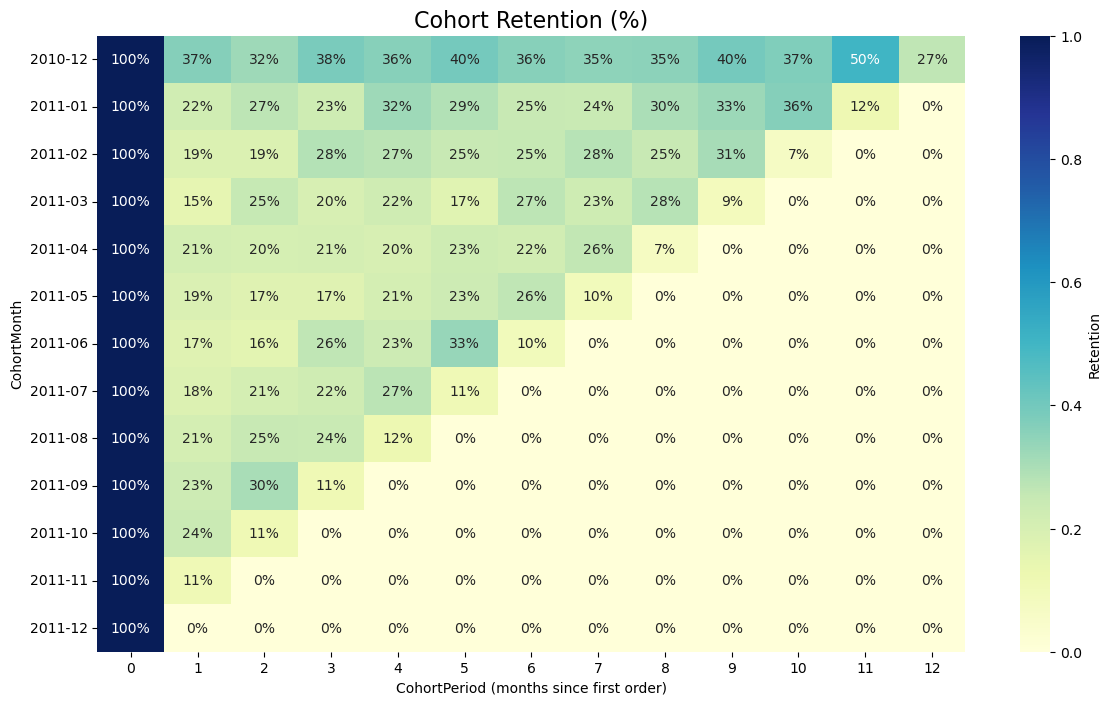

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# cohort_retention should be a DataFrame:
# rows = CohortMonth (datetime index), columns = CohortPeriod (0, 1, 2,...), values = retention %

plt.figure(figsize=(14, 8))

sns.heatmap(
    cohort_retention,
    annot=True,       # write numbers inside cells
    fmt=".0%",        # format as percentages
    cmap="YlGnBu",    # color scheme (yellow-green-blue)
    cbar_kws={"label": "Retention"}  # label for colorbar
)

plt.title("Cohort Retention (%)", fontsize=16)
plt.xlabel("CohortPeriod (months since first order)")
plt.ylabel("CohortMonth")

# Make CohortMonth show up as YYYY-MM
plt.yticks(
    ticks=[i + 0.5 for i in range(len(cohort_retention.index))],  # center labels
    labels=[c.strftime("%Y-%m") for c in cohort_retention.index],
    rotation=0
)

plt.show()


### Cohort Retention Analysis

The heatmap above shows **customer retention by cohort**:

- **Y-axis (CohortMonth)**: the month when customers were first acquired.  
- **X-axis (CohortPeriod)**: months since that first purchase (0 = acquisition month, 1 = the following month, etc.).  
- **Each cell**: the % of customers from that cohort who placed at least one order in that period.  
  Column 0 is always 100%, since all customers buy in their first month.

#### Key observations
- Retention **drops sharply after the first month**. Only about **15–37%** of customers return in month 1 depending on the cohort.  
- Some cohorts show **seasonal spikes** around periods 10–11 (October–November), especially for the Dec 2010 cohort where retention briefly jumps to ~50%.  
- Older cohorts (top rows) have a full 12-month view. Newer cohorts are truncated because the dataset ends in Dec 2011.

#### Why this matters
- The **first 30 days are critical**. Customers who don’t make a repeat purchase quickly are unlikely to return later.  
- The visible spike in Oct–Nov suggests **holiday-driven reactivation**. This highlights the value of targeted campaigns during seasonal peaks.  
- Cohort analysis like this allows us to separate growth due to **new acquisitions** versus **retention of existing customers**, giving better insight into long-term sustainability.



## Revenue Retention Analysis

So far, we looked at customer retention by tracking the percentage of buyers from each cohort who returned in later months.  
But retention is not only about the number of customers — it’s also about how much they spend.  

Revenue retention gives us a value-based view:
- **Customer retention** = % of people who come back.  
- **Revenue retention** = % of initial revenue that repeats in later months.  

This often tells a different story: sometimes fewer customers return, but those who do are the high-value buyers, so the revenue decay is slower.  
The next step is to calculate and visualise revenue retention using the same cohort framework as before.


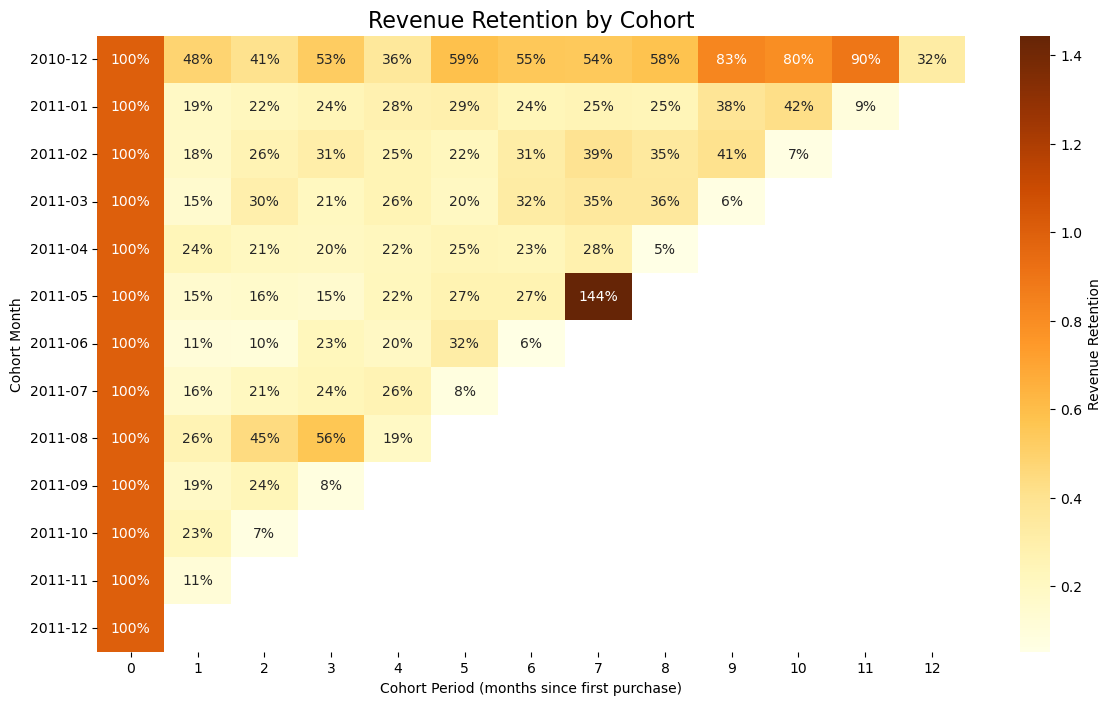

In [25]:
#1) Cohort Revenue by Period

# Revenue by CohortMonth and CohortPeriod
cohort_revenue = (
    orders.groupby(["CohortMonth", "CohortPeriod"])["Revenue"]
    .sum()
    .reset_index()
)


# Calculate revenue retention directly in this format
cohort_revenue["CohortStartRevenue"] = cohort_revenue.groupby("CohortMonth")["Revenue"].transform("first")
cohort_revenue["RevenueRetention"] = cohort_revenue["Revenue"] / cohort_revenue["CohortStartRevenue"]

# Save this version — perfect for Power BI or Tableau
cohort_revenue.to_csv("D:\DataScienceProjects\DataSets\online_retail_dataset\cohort_revenue_retention.csv", index=False)


# Pivot into matrix
cohort_revenue_matrix = cohort_revenue.pivot(
    index="CohortMonth", 
    columns="CohortPeriod", 
    values="Revenue"
)

#2) Convert to Retention %

# Divide each row by its first value (month 0 revenue)
cohort_revenue_retention = cohort_revenue_matrix.divide(
    cohort_revenue_matrix.iloc[:, 0], axis=0
)


#3) Plot Heatmap

plt.figure(figsize=(14, 8))
sns.heatmap(
    cohort_revenue_retention,
    annot=True, fmt=".0%", cmap="YlOrBr",
    cbar_kws={"label": "Revenue Retention"}
)

plt.title("Revenue Retention by Cohort", fontsize=16)
plt.xlabel("Cohort Period (months since first purchase)")
plt.ylabel("Cohort Month")

# Better labels for CohortMonth
plt.yticks(
    ticks=[i + 0.5 for i in range(len(cohort_revenue_retention.index))],
    labels=[c.strftime("%Y-%m") for c in cohort_revenue_retention.index],
    rotation=0
)

plt.show()



### Revenue Retention Analysis

This heatmap shows how much revenue from each monthly cohort is retained over time.  
Unlike customer retention, which measures the % of buyers returning, revenue retention reflects the value of those buyers.  

Key Observations:
- Retention drops sharply after the first month, but revenue declines more slowly than customer counts. This means that although fewer customers return, those who do tend to spend more.  
- Some cohorts show seasonal spikes (e.g., September, October and November), indicating reactivation around holidays.  
- Mature cohorts stabilise at a low percentage, representing the core loyal customers who keep generating consistent revenue.  

Takeaway: focusing on **early re-engagement** can help capture lost customers, while investing in **loyal customer programs** will preserve the steady revenue base.


## Step 8: Purchase Frequency
How often customers buy (number of orders per customer per time window).


In [14]:
purchase_freq = (
    orders.groupby("CustomerID")["InvoiceNo"]
    .nunique()
    .reset_index(name = "OrderCount")

)

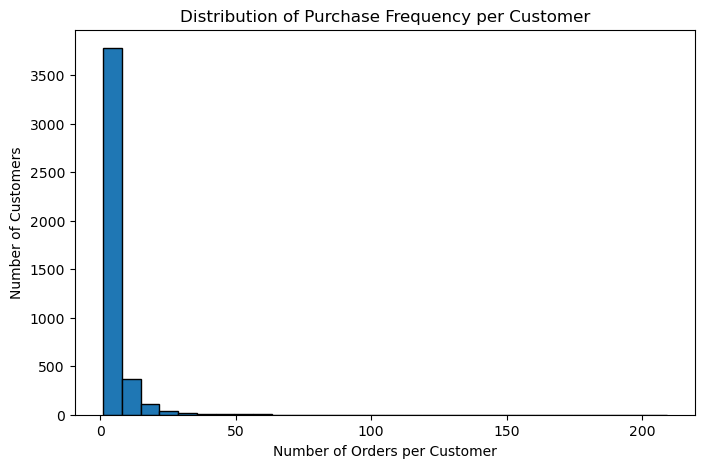

In [15]:
# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(purchase_freq["OrderCount"], bins=30, edgecolor="black")
plt.title("Distribution of Purchase Frequency per Customer")
plt.xlabel("Number of Orders per Customer")
plt.ylabel("Number of Customers")
plt.show()

Interpretation of Purchase Frequency Distribution

1. The majority of customers purchased only once
The huge spike near 1 order per customer shows that a large portion of buyers are one-time shoppers. This means customer acquisition is happening, but retention is weak — most customers never return.

2. A small segment makes multiple purchases
The long tail (stretching toward 50–200 orders) indicates a small group of highly loyal or repeat customers. They’re few in number, but they likely contribute disproportionately to total revenue (power customers).

3. Strong skewness
The distribution is heavily right-skewed, meaning customer engagement drops off quickly after the first purchase. This pattern is typical in e-commerce, but it signals opportunity for retention strategies — loyalty programs, email re-engagement, or personalized offers.

4. Business implication
The company’s growth challenge isn’t acquiring customers — it’s keeping them.
A retention uplift (even 5–10%) could significantly raise total revenue, given the size of the one-time buyer base.

## Step 9: Customer Lifetime Value (CLV) Estimation

The goal is to estimate how much revenue each customer generates across their entire observed relationship — and compare groups (new, repeat, loyal, etc.).

1. Calculate CLV metrics per customer

In [16]:
clv = (
    orders.groupby("CustomerID", as_index=False)
          .agg(
              TotalRevenue=("Revenue", "sum"),
              Orders=("InvoiceNo", "nunique"),
              FirstPurchase=("OrderDate", "min"),
              LastPurchase=("OrderDate", "max")
          )
)

# Calculate customer 'lifetime' in days
clv["DaysActive"] = (clv["LastPurchase"] - clv["FirstPurchase"]).dt.days

# Calculate average order value and purchase frequency
clv["AvgOrderValue"] = clv["TotalRevenue"] / clv["Orders"]
clv["PurchaseFreq"] = clv["Orders"] / (clv["DaysActive"]/30 + 1)


clv.head()


,CustomerID,TotalRevenue,Orders,FirstPurchase,LastPurchase,DaysActive,AvgOrderValue,PurchaseFreq
0,12346,77183.60,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,77183.600000,1.000000
1,12347,4310.00,7,2010-12-07 14:57:00,2011-12-07 15:52:00,365,615.714286,0.531646
2,12348,1797.24,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,449.310000,0.384615
3,12349,1757.55,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,1757.550000,1.000000
4,12350,334.40,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,334.400000,1.000000


2. Categorise Customers by Value Segment

In [28]:
clv["ValueSegment"] = pd.qcut(clv["TotalRevenue"], q=3, labels=["Low", "Medium", "High"])

clv.to_csv("D:\DataScienceProjects\DataSets\online_retail_dataset\customer_summary.csv")

3. Visualise CLV distribution

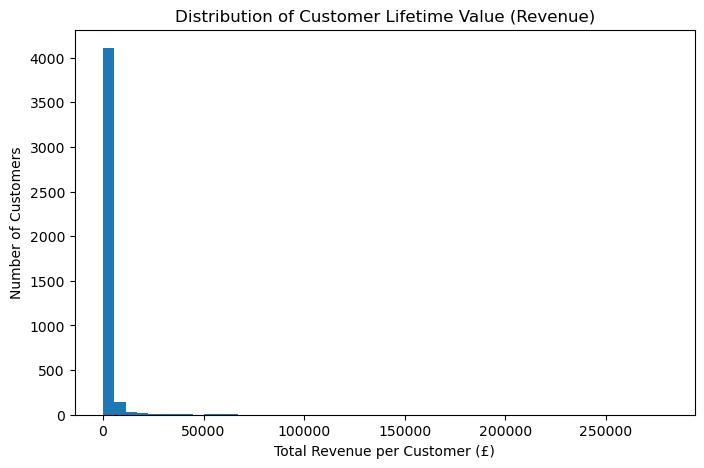

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(clv["TotalRevenue"], bins=50)
plt.title("Distribution of Customer Lifetime Value (Revenue)")
plt.xlabel("Total Revenue per Customer (£)")
plt.ylabel("Number of Customers")
plt.show()


Customer Lifetime Value (CLV) Analysis

Customer Lifetime Value (CLV) measures the total revenue each customer generates across their observed relationship with the business. By aggregating transactions per customer and calculating average order value, purchase frequency, and active days, the analysis revealed how customer value is distributed across the base.

Most customers fall into the lower-value segment, with a small portion driving a disproportionately high share of total revenue — a classic Pareto pattern. These high-value customers typically exhibit longer active periods and higher purchase frequencies, indicating stronger engagement and loyalty.

Segmenting customers into Low, Medium, and High value groups provides a clear foundation for targeted retention and marketing strategies, ensuring that high-value customers receive personalised attention while improving conversion among lower-value segments.

In [19]:
clv

,CustomerID,TotalRevenue,Orders,FirstPurchase,LastPurchase,DaysActive,AvgOrderValue,PurchaseFreq,ValueSegment
0,12346,77183.60,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,77183.600000,1.000000,High
1,12347,4310.00,7,2010-12-07 14:57:00,2011-12-07 15:52:00,365,615.714286,0.531646,High
2,12348,1797.24,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,449.310000,0.384615,High
3,12349,1757.55,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,1757.550000,1.000000,High
4,12350,334.40,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,334.400000,1.000000,Low
...,...,...,...,...,...,...,...,...,...
4333,18280,180.60,1,2011-03-07 09:52:00,2011-03-07 09:52:00,0,180.600000,1.000000,Low
4334,18281,80.82,1,2011-06-12 10:53:00,2011-06-12 10:53:00,0,80.820000,1.000000,Low
4335,18282,178.05,2,2011-08-05 13:35:00,2011-12-02 11:43:00,118,89.025000,0.405405,Low
4336,18283,2094.88,16,2011-01-06 14:14:00,2011-12-06 12:02:00,333,130.930000,1.322314,High
